# SERIES DE TIEMPO

- Importamos librerías necesarias:

In [1013]:
import pandas as pd
from time import mktime
from datetime import datetime, timedelta
import time
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_predict
from sklearn.metrics import r2_score
import numpy as np
import itertools
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="seaborn")

## ANÁLISIS EXPLORATORIO DE LOS DATOS (EDA)

### Exploración de la muestra

In [1014]:
data=pd.read_csv("C:/Users/ANGIE VANESA/TRABAJOS/PROYECTOS/TALENTO_B_2024/docs/stock_prices.csv")
data.head()

,Date,Stock1,Stock2,Stock3,Stock4,Stock5,Stock6
0,31/01/2000,110.803416,145.164513,89.967127,118.248015,116.158290,120.5747161
1,29/02/2000,110.011215,141.063683,92.335263,118.099936,127.103232,118.7053973
2,31/03/2000,112.395186,140.098690,91.217360,122.760796,124.294925,116.1646848
3,30/04/2000,113.591294,142.897176,91.945546,122.204326,132.652738,109.7337153
4,31/05/2000,113.981886,144.676906,89.175749,120.214614,129.143308,106.8073844


La muestra cuenta con 286 registros y 7 columnas:

In [1015]:
data.columns

Index(['Date', 'Stock1', 'Stock2', 'Stock3', 'Stock4', 'Stock5', 'Stock6'], dtype='object')

In [1016]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    286 non-null    object 
 1   Stock1  285 non-null    float64
 2   Stock2  285 non-null    float64
 3   Stock3  286 non-null    float64
 4   Stock4  286 non-null    float64
 5   Stock5  286 non-null    float64
 6   Stock6  286 non-null    object 
dtypes: float64(5), object(2)
memory usage: 15.8+ KB


In [1017]:
data['Stock6'][276:]

276    289;0646722
277    277.4177026
278    261.6371847
279    266.8832561
280    262.7783165
281    251.0994968
282    252.8305295
283    243.3028139
284    248.6698813
285    244.9508893
Name: Stock6, dtype: object

In [1018]:
data['Stock6'] = data['Stock6'].str.replace(';', '.')
data['Stock6'] = pd.to_numeric(data['Stock6'], errors='coerce')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    286 non-null    object 
 1   Stock1  285 non-null    float64
 2   Stock2  285 non-null    float64
 3   Stock3  286 non-null    float64
 4   Stock4  286 non-null    float64
 5   Stock5  286 non-null    float64
 6   Stock6  286 non-null    float64
dtypes: float64(6), object(1)
memory usage: 15.8+ KB


In [1019]:
data.shape

(286, 7)

Los registros de los precios para cada stock fueron tomados el último día de cada mes desde el 31 de enero del 2000 hasta el 31 de octubre del año actual 2023 

In [1020]:
data[-1:]

,Date,Stock1,Stock2,Stock3,Stock4,Stock5,Stock6
285,31/10/2023,121.825782,154.339357,177.925534,239.392154,368.286726,244.950889


#### Verificación de datos faltantes

Se procede a realizar la verificación de datos faltantes en la muestra:

In [1021]:
missing_data = data.isnull().sum()
print(missing_data)

Date      0
Stock1    1
Stock2    1
Stock3    0
Stock4    0
Stock5    0
Stock6    0
dtype: int64


Se encontraron dos datos faltantes en la muestra, especificamente en las columnas **stock1** y **stock2**, es necesario realizar una apropiada imputación de estos datos faltantes, para ello, se verificará primero cuales son exactamente estos registros faltantes:

In [1022]:
missing1=data[data["Stock1"].isnull()]
missing1

,Date,Stock1,Stock2,Stock3,Stock4,Stock5,Stock6
79,31/08/2006,NaN,129.333046,93.113845,136.536229,176.670296,149.809895


In [1023]:
missing2=data[data["Stock2"].isnull()]
missing2

,Date,Stock1,Stock2,Stock3,Stock4,Stock5,Stock6
170,31/03/2014,122.471407,NaN,102.369223,152.621697,304.850099,141.755669


### Imputación de datos faltantes

El éxito al modelar eficazmente está fuertemente influenciado por lo buena que sea la información de origen, así como por su accesibilidad, asegurándose además de que sea completa. A continuación se aplicaran técnicas para la imputación de datos faltantes en las series de tiempo de **Stock2** y **stock1**

El objetivo de la imputación es rellenar los valores perdidos con estimaciones (realizadas con el método de aprendizaje más apropiado para cada caso) de estos teniendo en cuenta las relaciones posibles entre las observaciones.existen diversos métodos de imputación diferenciados en la forma de estimar los datos faltantes, cuya elección preferible vendrá dada por la naturaleza de la serie:

- **Imputación mediante la media**: se reemplazan los valores perdidos por la media de los valores observados.

- **Imputación mediante regresión**: se estima una regresión de las observaciones existentes y se imputa cada valor perdido mediante la ecuación de regresión estimada.

- **Imputación mediante regresión estocástica**: similar al anterior pero se imputa añadiendo a la predicción un valor residual para reestablecer la pérdida de variabilidad.

- **Imputación mediante médias móviles**: se reemplazan las observaciones faltantes por los valores estimados mediante médias móviles.

- **Imputación por Last Observation Carried Forward (locf)**: reemplaza el dato perdido por la observacion que le precede.

Pero además de los métodos simples, también hay posibilidades adicionales más complejas para la imputación en series temporales univariantes:

- **Algoritmos multivariantes con datos retardados**: consisten en emplear indirectamente los algoritmos de series multivariantes en series univariantes empleando el tiempo (variable implícita de una serie temporal) como un atributo más. La forma habitual de hacer esto es mediante lags (variables que toman el valor de otra variable en un instante de tiempo previo) y leads (toman el valor de otra variable en un instante de tiempo posterior).

- **Filtro de Kalman con modelos ARIMA de espacio de estados**: todos los modelos ARIMA pueden ser reescritos (y estimados) como modelos en el espacio de estados. Estos modelos en el espacio de estados pueden entre otras muchas cosas estimar observaciones perdidas. Luego los principales beneficios de representar sistemas dinámicos en forma de espacio de estados es que el espacio de estados permite que las variables no observadas puedan ser incorporadas y estimadas junto con el modelo observable, y que además, estos modelos en el espacio de estados pueden ser analizados usando un algoritmo recursivo llamado filtro de Kalman (Kalman filter), que es usado, entre otras cosas, para determinar las estimaciones óptimas de los modelos en el espacio de estados.

Para el caso de la serie temporal **stock1**  y **stock2** se decidió aplicar un modelo de predicción de series de tiempo para pronosticar el valor faltante usando sus valores pasados. 

- Interpolación:

In [1024]:
data['Stock1'] = data['Stock1'].interpolate(method='linear')

In [1025]:
data['Stock2'] = data['Stock2'].interpolate(method='linear')

In [1026]:
missing_data = data.isnull().sum()
print(missing_data)

Date      0
Stock1    0
Stock2    0
Stock3    0
Stock4    0
Stock5    0
Stock6    0
dtype: int64


### Análisis descriptivo

In [1027]:
data.describe()

,Stock1,Stock2,Stock3,Stock4,Stock5,Stock6
count,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000
mean,118.993464,143.074648,113.071234,153.386488,232.467520,159.292093
std,6.337532,11.682642,29.419418,37.291854,61.283221,49.085530
min,107.912490,117.011712,79.948564,98.881841,116.158290,100.554122
25%,113.614764,134.451789,89.375663,123.342167,177.933480,120.602136
50%,119.350920,141.211706,98.082476,147.936460,241.293273,150.941387
75%,123.786876,153.660505,142.054831,166.906185,278.979693,177.060917
max,130.289727,169.938853,215.492450,259.633973,386.009285,321.334913


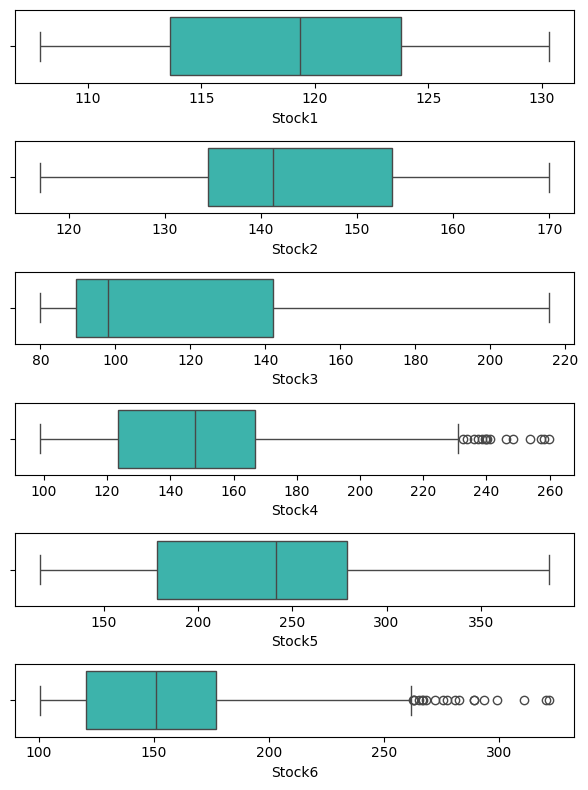

In [1028]:
fig, axs = plt.subplots(nrows=6, ncols=1, figsize=(6, 8))
columns_to_plot = ['Stock1', 'Stock2', 'Stock3', 'Stock4', 'Stock5', 'Stock6']
for i, column in enumerate(columns_to_plot):
    sns.boxplot(data=data[column], color='#2AC6BC', ax=axs[i], orient='h')
plt.tight_layout()
plt.show()

- **stock1** : Esta acción cuenta con un precio promedio de 118.99 aproximadamente, con una desviación estandar de 6.33. Hay 286 registros. el 50% de los precios registrados para esta acción están por encima de 119.35

- **stock2** : Esta acción cuenta con un precio promedio de 143.07 con una desviación estándar de 11.68. desde el 2000 hasta el 2023 se han encontrado registros de precios mínimo de 117.01 y máximo 169.93.

- **stocks 3, 4 y 5** :Las tres acciones cuentan con registros de precios máximo sobre los 200, siendo el stock5 aquella con el mayor valor alcanzado, de 386.00. En general, el stock5 tiene el precio promedio más alto, aproximadamente de 232.46 con una desviación estándar de 61.28.

### Serie de tiempo: Tendencia y estacionariedad

Una operación fundamental para entender el comportamiento de una serie de tiempo y poder determinar si se trata de una serie estacionaria o no; es realizar gráficos de la misma.

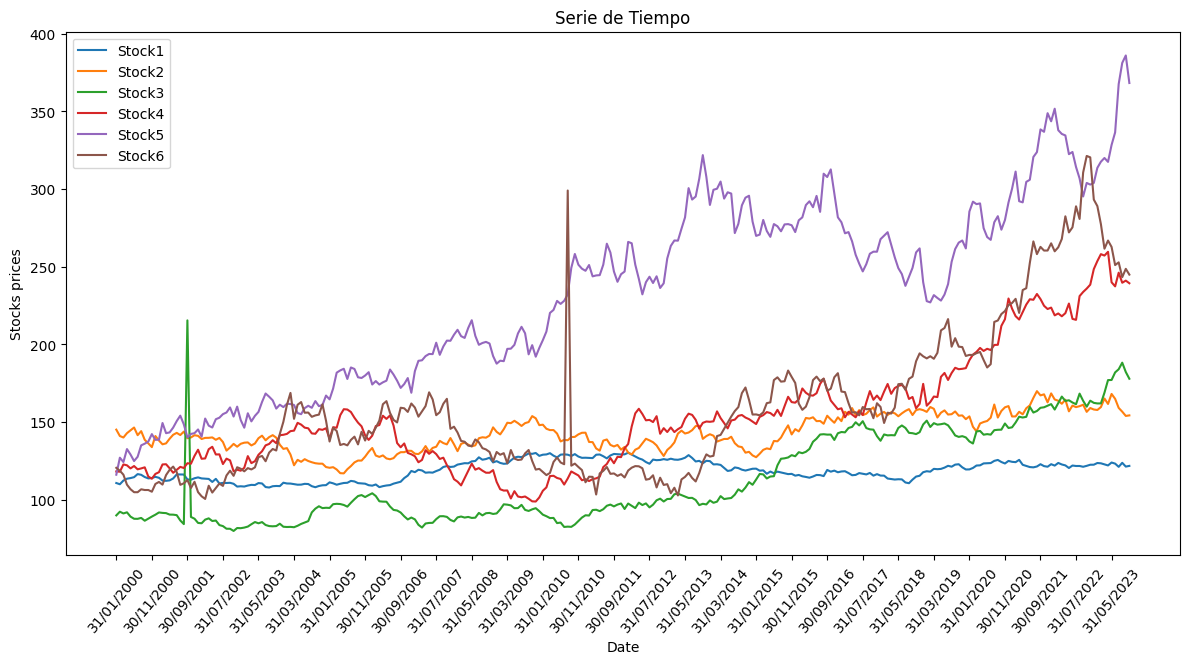

In [1029]:
plt.figure(figsize = (12,6))
ax = sns.lineplot(data=data, x="Date", y=data["Stock1"], label="Stock1" )
ax1 = sns.lineplot(data=data, x="Date", y=data["Stock2"],label="Stock2")
ax2 = sns.lineplot(data=data, x="Date", y=data["Stock3"], label="Stock3")
ax3 = sns.lineplot(data=data, x="Date", y=data["Stock4"], label="Stock4")
ax4 = sns.lineplot(data=data, x="Date", y=data["Stock5"], label="Stock5")
ax5 = sns.lineplot(data=data, x="Date", y=data["Stock6"], label="Stock6")
freq = int(10)
xtix = ax.get_xticks()
ax.set_xticks(xtix[::freq])
plt.tight_layout()
plt.title("Serie de Tiempo")
plt.ylabel('Stocks prices')
plt.xticks(rotation=50);

De la figura anterior, podemos ver la ausencia de estacionariedad en las series de tiempo.sin embargo se realizará la prueba ADF para verificar dicha hipótesis. 

- Ho: No estacionariedad

- H1: Estacionariedad

In [1030]:
def prueba_ADF(stock):
    result = adfuller(stock)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

In [1031]:
prueba_ADF(data['Stock1'])

ADF Statistic: -1.795419
p-value: 0.382739


In [1032]:
prueba_ADF(data['Stock2'])

ADF Statistic: -1.697034
p-value: 0.432641


In [1033]:
prueba_ADF(data["Stock3"])

ADF Statistic: 0.576606
p-value: 0.987025


In [1034]:
prueba_ADF(data["Stock4"])

ADF Statistic: 0.115406
p-value: 0.967097


In [1035]:
prueba_ADF(data["Stock5"])

ADF Statistic: -0.742085
p-value: 0.835545


In [1036]:
prueba_ADF(data["Stock6"])

ADF Statistic: -0.878949
p-value: 0.794826


Dado que el p-valor es mayor que el nivel de significancia (0.05), no se rechaza la hipótesis nula. Las series de tiempo son no estacionaria. 

## ANÁLISIS EXPLORATORIO DE LOS RETORNOS

Los retornos de acciones proporcionan una medida cuantitativa del rendimiento de una inversión. Al analizar los retornos, los inversores pueden evaluar el éxito o fracaso de sus decisiones de inversión y comparar el rendimiento de diferentes activos. El análisis de retornos puede guiar las decisiones sobre cuándo comprar, vender o retener acciones. A continuación, se determinan y analizan los retornos de las acciones registradas en la muestra:

- Retorno compuesto o logarítimo:

In [1037]:
data['Retornos_stock1'] = np.log( data['Stock1']/data['Stock1'].shift(1)).fillna(0)
data['Retornos_stock2'] = np.log( data['Stock2']/data['Stock2'].shift(1)).fillna(0)
data['Retornos_stock3'] = np.log( data['Stock3']/data['Stock3'].shift(1)).fillna(0)
data['Retornos_stock4'] = np.log( data['Stock4']/data['Stock4'].shift(1)).fillna(0)
data['Retornos_stock5'] = np.log( data['Stock5']/data['Stock5'].shift(1)).fillna(0)
data['Retornos_stock6'] = np.log( data['Stock6']/data['Stock6'].shift(1)).fillna(0)

In [1038]:
retorno=pd.DataFrame(data[['Retornos_stock1','Retornos_stock2','Retornos_stock3','Retornos_stock4', 'Retornos_stock5','Retornos_stock6']])
retorno.head()

,Retornos_stock1,Retornos_stock2,Retornos_stock3,Retornos_stock4,Retornos_stock5,Retornos_stock6
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-0.007175,-0.028656,0.025982,-0.001253,0.090046,-0.015625
2,0.021439,-0.006864,-0.012181,0.038707,-0.022342,-0.021636
3,0.010586,0.019778,0.007951,-0.004543,0.065078,-0.056952
4,0.003433,0.012378,-0.030587,-0.016416,-0.026812,-0.027030


In [1039]:
retorno.describe().T

,count,mean,std,min,25%,50%,75%,max
Retornos_stock1,286.0,0.000332,0.009798,-0.027453,-0.005612,0.000141,0.006080,0.033712
Retornos_stock2,286.0,0.000214,0.020246,-0.058772,-0.013226,0.001381,0.013733,0.053955
Retornos_stock3,286.0,0.002384,0.078731,-0.884606,-0.010977,0.001261,0.015410,0.937853
Retornos_stock4,286.0,0.002466,0.028120,-0.083999,-0.014265,0.002200,0.020192,0.079910
Retornos_stock5,286.0,0.004035,0.031855,-0.089447,-0.019638,0.005940,0.024927,0.090046
Retornos_stock6,286.0,0.002478,0.084462,-0.896936,-0.019285,0.003687,0.026027,0.889483


### Serie de tiempo y su retorno mensual compuesto

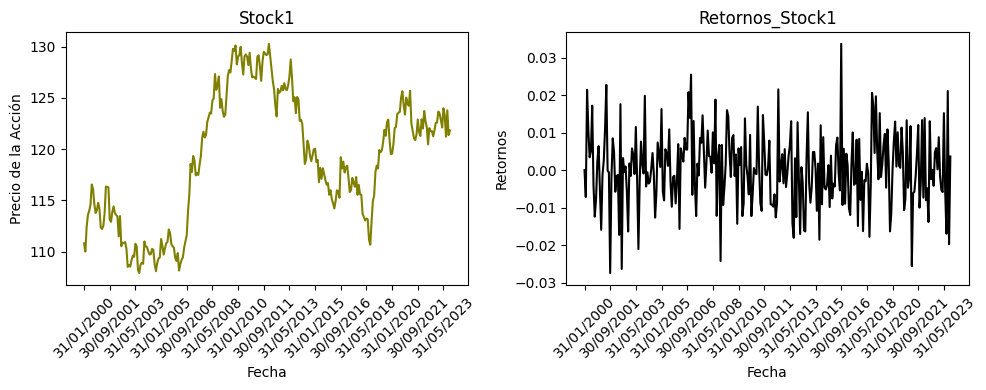

In [1040]:
# Acción 1
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(data['Date'], data['Stock1'], color='olive')
plt.title('Stock1')
plt.xlabel('Fecha')
plt.ylabel('Precio de la Acción')

n = 20
plt.xticks(rotation=45)
plt.xticks(range(0, len(data['Date']), n), data['Date'][::n])

# Gráfico para Retornos_Stock1
plt.subplot(1, 2, 2)
plt.plot(data['Date'], data['Retornos_stock1'], color='black')
plt.title('Retornos_Stock1')
plt.xlabel('Fecha')
plt.ylabel('Retornos')

n = 20
plt.xticks(rotation=45)
plt.xticks(range(0, len(data['Date']), n), data['Date'][::n])

plt.tight_layout()
plt.show()



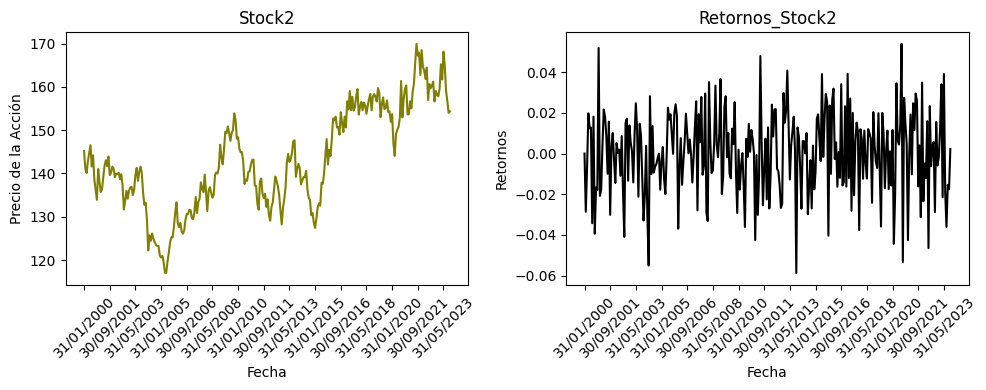

In [1041]:
# Acción 2
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(data['Date'], data['Stock2'], color='olive')
plt.title('Stock2')
plt.xlabel('Fecha')
plt.ylabel('Precio de la Acción')

n = 20
plt.xticks(rotation=45)
plt.xticks(range(0, len(data['Date']), n), data['Date'][::n])

# Gráfico para Retornos_Stock2
plt.subplot(1, 2, 2)
plt.plot(data['Date'], data['Retornos_stock2'], color='black')
plt.title('Retornos_Stock2')
plt.xlabel('Fecha')
plt.ylabel('Retornos')

n = 20
plt.xticks(rotation=45)
plt.xticks(range(0, len(data['Date']), n), data['Date'][::n])

plt.tight_layout()
plt.show()

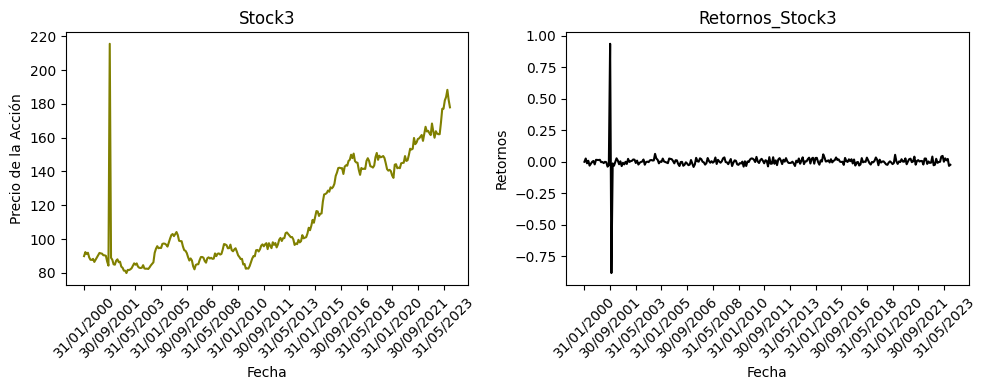

In [1042]:
# Acción 3
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(data['Date'], data['Stock3'], color='olive')
plt.title('Stock3')
plt.xlabel('Fecha')
plt.ylabel('Precio de la Acción')

n = 20
plt.xticks(rotation=45)
plt.xticks(range(0, len(data['Date']), n), data['Date'][::n])

# Gráfico para Retornos_Stock2
plt.subplot(1, 2, 2)
plt.plot(data['Date'], data['Retornos_stock3'], color='black')
plt.title('Retornos_Stock3')
plt.xlabel('Fecha')
plt.ylabel('Retornos')

n = 20
plt.xticks(rotation=45)
plt.xticks(range(0, len(data['Date']), n), data['Date'][::n])

plt.tight_layout()
plt.show()

De gráfico anterior, vemos que la serie de tiempo para el Stock3 no es estacionaria, muestra cierta tendencia, pero también, hay un registro que podría ser un posible dato atípico, el cual se analizará en la siguiente sección.

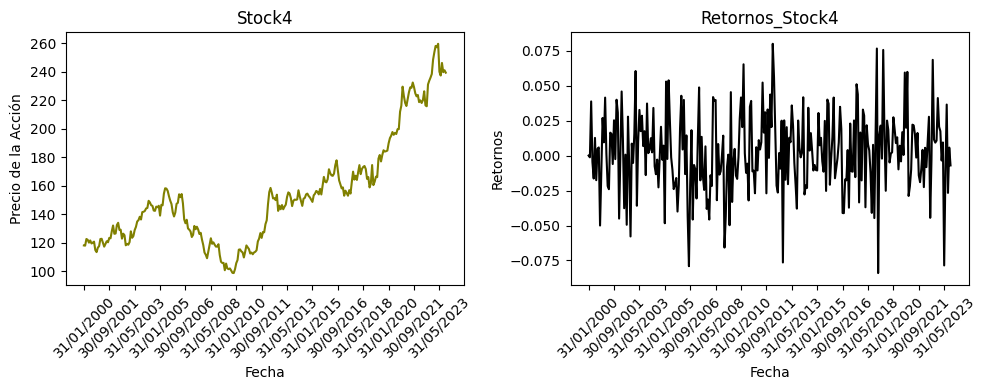

In [1043]:
# Acción 4
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(data['Date'], data['Stock4'], color='olive')
plt.title('Stock4')
plt.xlabel('Fecha')
plt.ylabel('Precio de la Acción')

n = 20
plt.xticks(rotation=45)
plt.xticks(range(0, len(data['Date']), n), data['Date'][::n])

# Gráfico para Retornos_Stock2
plt.subplot(1, 2, 2)
plt.plot(data['Date'], data['Retornos_stock4'], color='black')
plt.title('Retornos_Stock4')
plt.xlabel('Fecha')
plt.ylabel('Retornos')

n = 20
plt.xticks(rotation=45)
plt.xticks(range(0, len(data['Date']), n), data['Date'][::n])

plt.tight_layout()
plt.show()

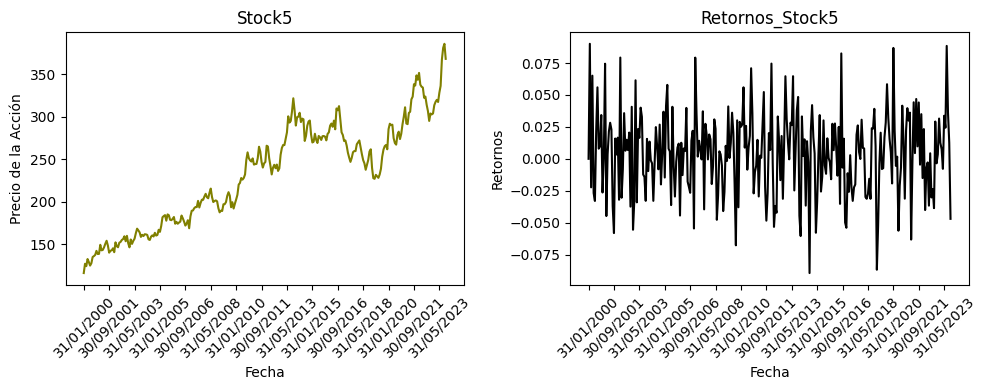

In [1044]:
# Acción 5
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(data['Date'], data['Stock5'], color='olive')
plt.title('Stock5')
plt.xlabel('Fecha')
plt.ylabel('Precio de la Acción')

n = 20
plt.xticks(rotation=45)
plt.xticks(range(0, len(data['Date']), n), data['Date'][::n])

# Gráfico para Retornos_Stock2
plt.subplot(1, 2, 2)
plt.plot(data['Date'], data['Retornos_stock5'], color='black')
plt.title('Retornos_Stock5')
plt.xlabel('Fecha')
plt.ylabel('Retornos')

n = 20
plt.xticks(rotation=45)
plt.xticks(range(0, len(data['Date']), n), data['Date'][::n])

plt.tight_layout()
plt.show()

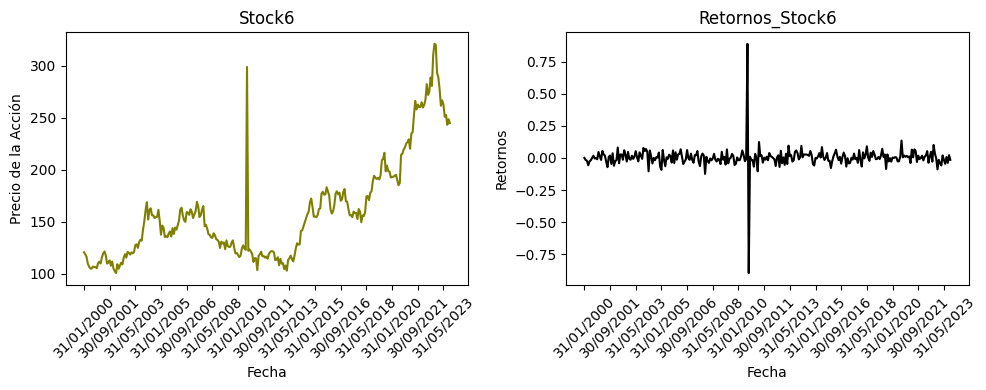

In [1045]:
# Acción 1
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(data['Date'], data['Stock6'], color='olive')
plt.title('Stock6')
plt.xlabel('Fecha')
plt.ylabel('Precio de la Acción')

n = 20
plt.xticks(rotation=45)
plt.xticks(range(0, len(data['Date']), n), data['Date'][::n])

# Gráfico para Retornos_Stock1
plt.subplot(1, 2, 2)
plt.plot(data['Date'], data['Retornos_stock6'], color='black')
plt.title('Retornos_Stock6')
plt.xlabel('Fecha')
plt.ylabel('Retornos')

n = 20
plt.xticks(rotation=45)
plt.xticks(range(0, len(data['Date']), n), data['Date'][::n])

plt.tight_layout()
plt.show()

Podemos ver que los precios de la acción no son una serie de tiempo estacionaria, puesto que tienen tendencia y varianza variables a lo largo del tiempo. La serie de tiempo de retornos, por otra parte, parece tener medias y varianza más estables a través del tiempo, por lo que sería más factible predecir su movimiento futuro.

### Diagrama de cajas

El siguiente diagrama de cajas muestra que hay posibles datos atípicos en los retornos de las acciones, tanto positivos como negativos.

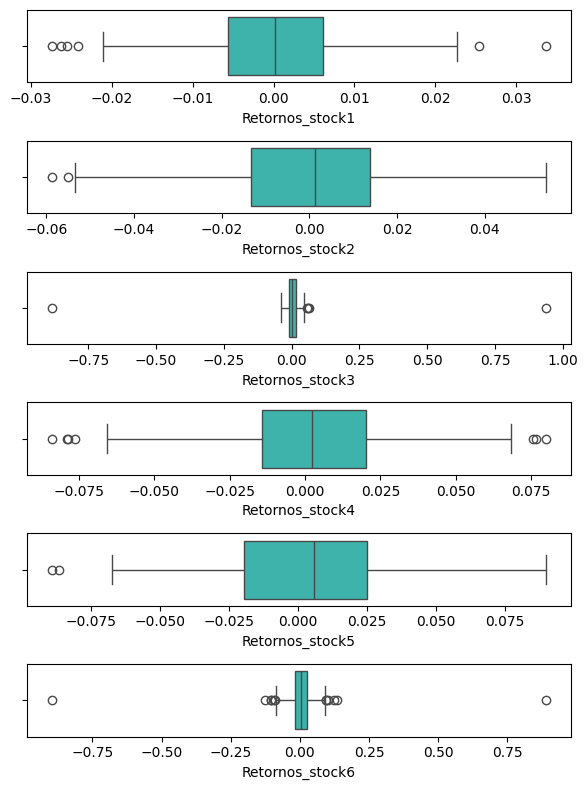

In [1046]:
fig, axs = plt.subplots(nrows=6, ncols=1, figsize=(6, 8))
columns_to_plot = ['Retornos_stock1', 'Retornos_stock2', 'Retornos_stock3', 'Retornos_stock4', 'Retornos_stock5','Retornos_stock6']
for i, column in enumerate(columns_to_plot):
    sns.boxplot(data=retorno[column], color='#2AC6BC', ax=axs[i], orient='h')
plt.tight_layout()
plt.show()

El siguiente gráfico corresponde a un histograma de los retornos de las acciones, los cuales nos muestran que:

- El registro de retorno más alto en todas las acciones tuvo poca frecuencia. 


### Histograma

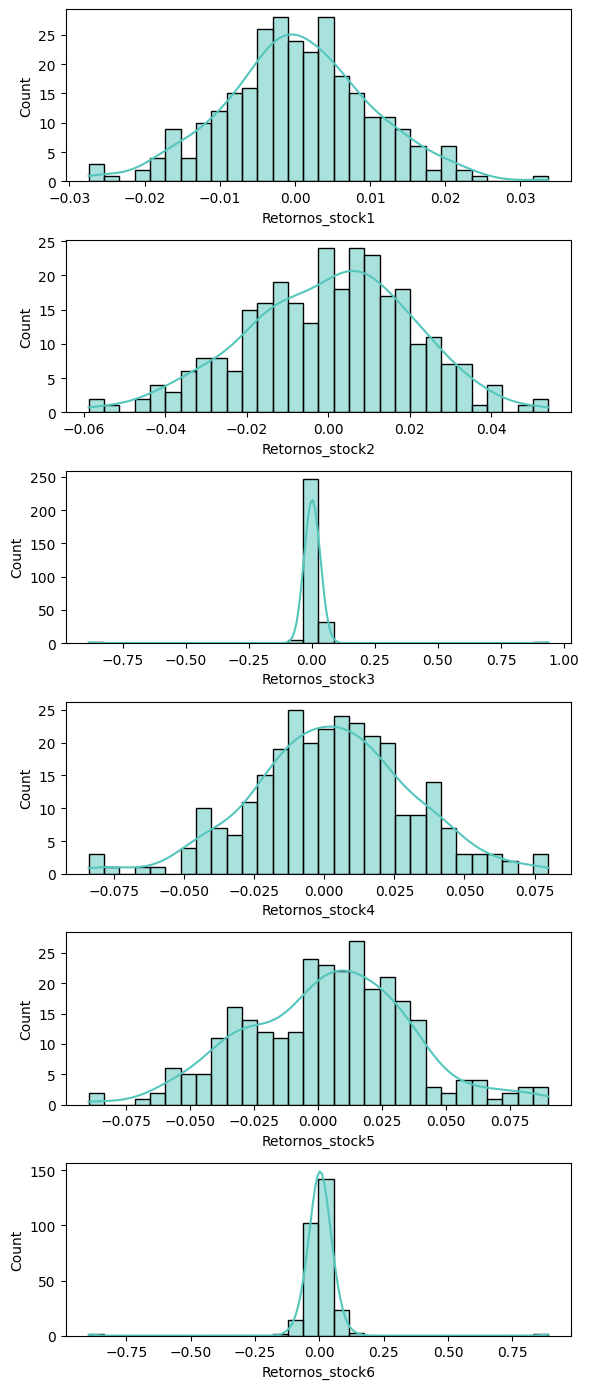

In [1047]:
fig, axs = plt.subplots(nrows=6, ncols=1, figsize=(6, 14))
columns_to_plot = ['Retornos_stock1', 'Retornos_stock2', 'Retornos_stock3', 'Retornos_stock4', 'Retornos_stock5', 'Retornos_stock6']
for i, column in enumerate(columns_to_plot):
    sns.histplot(retorno[column], bins=30, color='#55C6BC', kde=True, ax=axs[i])
plt.tight_layout()
plt.show()

### Q-Q (Quantile-Quantile)

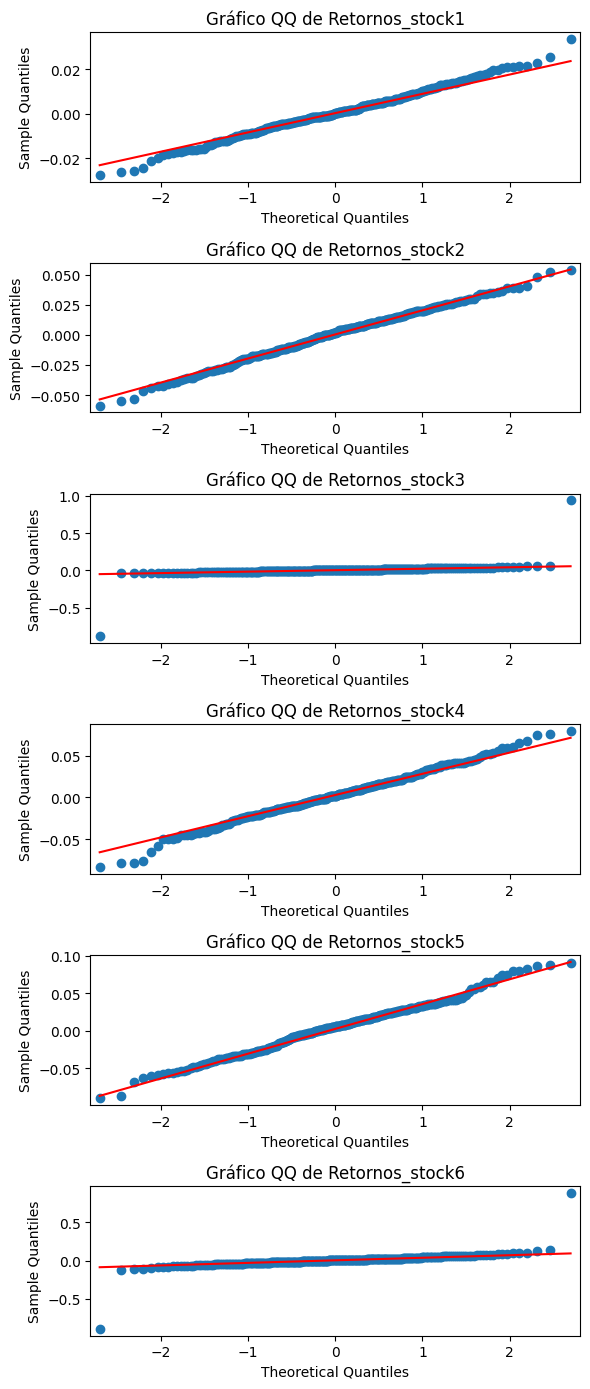

In [1048]:
fig, axs = plt.subplots(nrows=6, ncols=1, figsize=(6, 14))
columns_to_plot = ['Retornos_stock1', 'Retornos_stock2', 'Retornos_stock3', 'Retornos_stock4', 'Retornos_stock5','Retornos_stock6']
for i, column in enumerate(columns_to_plot):
    sm.qqplot(retorno[column], line='q', ax=axs[i] )
    axs[i].set_title(f'Gráfico QQ de {column}')
plt.tight_layout()
plt.show()

Los retornos parecen ser normales, con algunos datos alejados en las colas, se sugiere hacer una prueba de normalidad

### Gráficas de autocorrelación

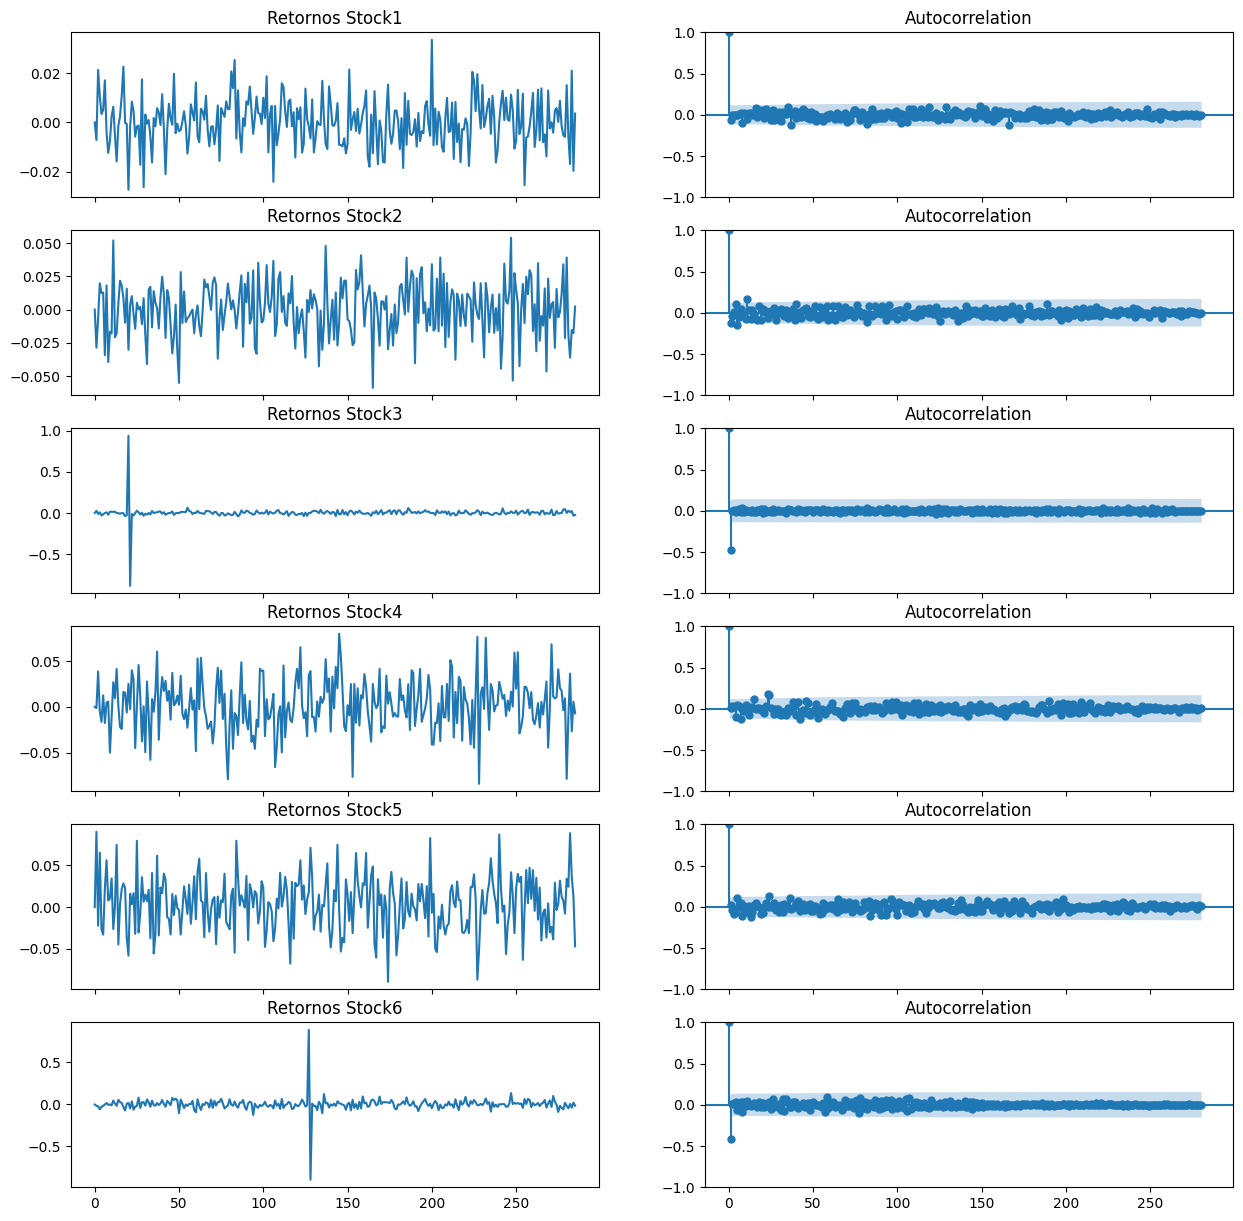

In [1049]:
plt.rcParams.update({'figure.figsize': (15,15)})

fig, axes = plt.subplots(6, 2, sharex=True)
axes[0, 0].plot(retorno.Retornos_stock1); axes[0, 0].set_title('Retornos Stock1')
plot_acf(retorno.Retornos_stock1, ax=axes[0, 1], lags = 280);

axes[1, 0].plot(retorno.Retornos_stock2); axes[1, 0].set_title('Retornos Stock2')
plot_acf(retorno.Retornos_stock2, ax=axes[1, 1], lags = 280);

axes[2, 0].plot(retorno.Retornos_stock3); axes[2, 0].set_title('Retornos Stock3')
plot_acf(retorno.Retornos_stock3, ax=axes[2, 1], lags = 280);

axes[3, 0].plot(retorno.Retornos_stock4); axes[3, 0].set_title('Retornos Stock4')
plot_acf(retorno.Retornos_stock4, ax=axes[3, 1], lags = 280);

axes[4, 0].plot(retorno.Retornos_stock5); axes[4, 0].set_title('Retornos Stock5')
plot_acf(retorno.Retornos_stock5, ax=axes[4, 1], lags = 280);

axes[5, 0].plot(retorno.Retornos_stock6); axes[5, 0].set_title('Retornos Stock6')
plot_acf(retorno.Retornos_stock6, ax=axes[5, 1], lags = 280);

## Correlaciones históricas y dinámicas

### Correlaciones históricas

- Mapa de calor:

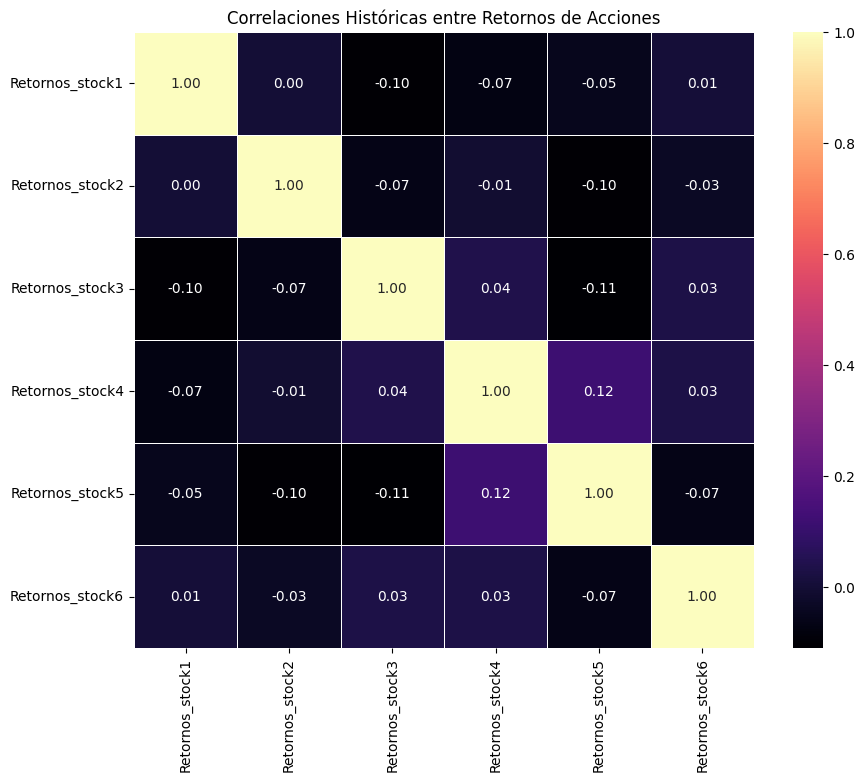

In [1050]:
correlaciones_totales = retorno.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlaciones_totales, annot=True, cmap='magma', fmt='.2f', linewidths=.5)
plt.title('Correlaciones Históricas entre Retornos de Acciones')
plt.show()

Del mapa de calor anterior, podemos ver que no hay correlaciones históricas fuertes entre los retornos de las acciones.

### Correlaciones dinámicas: Stock5 y Stock6

In [1051]:
retorno.head()

,Retornos_stock1,Retornos_stock2,Retornos_stock3,Retornos_stock4,Retornos_stock5,Retornos_stock6
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-0.007175,-0.028656,0.025982,-0.001253,0.090046,-0.015625
2,0.021439,-0.006864,-0.012181,0.038707,-0.022342,-0.021636
3,0.010586,0.019778,0.007951,-0.004543,0.065078,-0.056952
4,0.003433,0.012378,-0.030587,-0.016416,-0.026812,-0.027030


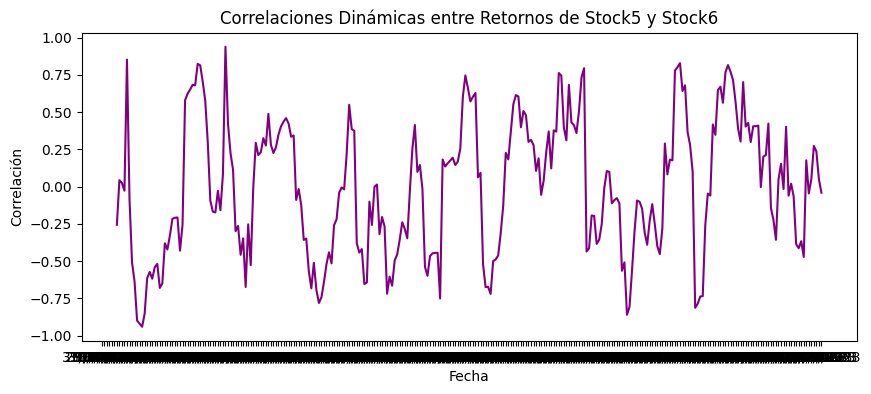

In [1053]:
horizonte = 7
correlaciones_dinamicas = retorno['Retornos_stock5'].rolling(window=horizonte).corr(retorno['Retornos_stock6'])
plt.figure(figsize=(10, 4))
plt.plot(data['Date'], correlaciones_dinamicas, color='purple')
plt.title('Correlaciones Dinámicas entre Retornos de Stock5 y Stock6')
plt.xlabel('Fecha')
plt.ylabel('Correlación')
plt.show()

## DECISIÓN

¿Si tuvieras que elegir en que acción invertir, ¿cuál elegirías? Evalúa tanto los potenciales retornos, como los riesgos asociados ?

## MODELAMIENTO

Modela los retornos de la acción 5 con base en los retornos de las demás acciones.